In [49]:
import polars as pl
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy import sqrt, dot
import seaborn as sns

In [50]:
sns.set_theme()

In [51]:
def R2(y_pred: pl.Series, y_obs: pl.DataFrame):
    return 1 - ((y_pred - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def Q2(y_hat: pl.Series, y_obs: pl.DataFrame):
    return 1 - ((y_hat - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def RMSE(y_hat: pl.Series, y_obs: pl.DataFrame):
    return (((y_hat - y_obs.to_series())**2).sum()/y_obs.shape[0])**0.5

def F(y_pred: pl.Series, y_obs: pl.DataFrame, descriptor_number: int):
    return (((y_pred - y_pred.mean())**2).sum() / (y_pred.shape[0] - 1)) / (((y_obs.to_series() - y_pred)**2).sum() / (y_pred.shape[0] - descriptor_number - 1))

In [52]:
dane_leki = pl.read_excel(
                source="dane_leki.xlsx",
                columns=list(range(1,8))
)

In [53]:
dane_leki.head()

Nazwa,logK HSA,logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA,Zbiór
str,f64,f64,i64,i64,i64,str
"""acetaminophen""",-0.79,-0.63,2,0,2,"""t"""
"""acetylsalicylic acid""",-0.23,1.22,1,0,4,"""t"""
"""bromazepam""",0.38,0.57,1,0,3,"""t"""
"""carbamazepine""",0.69,0.68,0,0,3,"""t"""
"""chlorpromazine""",1.18,1.5,0,0,2,"""t"""


In [54]:
Y = dane_leki.select(pl.col('Nazwa'), pl.col("logK HSA"))

In [55]:
Y.head()

Nazwa,logK HSA
str,f64
"""acetaminophen""",-0.79
"""acetylsalicylic acid""",-0.23
"""bromazepam""",0.38
"""carbamazepine""",0.69
"""chlorpromazine""",1.18


In [56]:
X = dane_leki.select(
    pl.exclude(["logK HSA", "Zbiór"])
)

In [57]:
X.head()

Nazwa,logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
str,f64,i64,i64,i64
"""acetaminophen""",-0.63,2,0,2
"""acetylsalicylic acid""",1.22,1,0,4
"""bromazepam""",0.57,1,0,3
"""carbamazepine""",0.68,0,0,3
"""chlorpromazine""",1.5,0,0,2


In [58]:
Y_trening = dane_leki.filter(
    pl.col("Zbiór") == 't'
).select(
    pl.col("logK HSA")
)

In [59]:
Y_trening.head()

logK HSA
f64
-0.79
-0.23
0.38
0.69
1.18


In [60]:
Y_walidacja = dane_leki.filter(
    pl.col("Zbiór") == 'w'
).select(
    pl.col("logK HSA")
)

In [61]:
Y_walidacja.head()

logK HSA
f64
-1.25
1.69
-0.77
1.84
1.82


In [62]:
X_trening = dane_leki.filter(
    pl.col("Zbiór") == 't'
).select(
    pl.exclude(["Nazwa", "logK HSA", "Zbiór"])
)

In [63]:
X_trening.head()

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,i64,i64,i64
-0.63,2,0,2
1.22,1,0,4
0.57,1,0,3
0.68,0,0,3
1.5,0,0,2


In [64]:
X_walidacja = dane_leki.filter(
    pl.col("Zbiór") == 'w'
).select(
    pl.exclude(["Nazwa", "logK HSA", "Zbiór"])
)

In [65]:
X_walidacja.head()

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,i64,i64,i64
-0.11,3,0,6
1.98,0,1,3
0.01,4,1,5
0.73,0,5,2
1.63,1,4,5


In [66]:
corr_matrix = X.select(
    pl.exclude("Nazwa")
).corr()

In [67]:
corr_matrix

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,f64,f64,f64
1.0,-0.633481,0.446144,-0.135951
-0.633481,1.0,-0.291248,0.290864
0.446144,-0.291248,1.0,0.326375
-0.135951,0.290864,0.326375,1.0


In [68]:
linear_model = LinearRegression().fit(X_trening, Y_trening)

In [69]:
linear_model.coef_

array([[ 0.47223989, -0.21607308,  0.32315214, -0.22529295]])

In [70]:
linear_model.intercept_

array([0.80501409])

In [71]:
pred_Y_trening = pl.Series(linear_model.predict(X_trening).reshape(-1))
pred_Y_walidacja = pl.Series(linear_model.predict(X_walidacja).reshape(-1))

# Rownanie modelu

$y \approx 0.472x_0 - 0.216x_1 + 0.323x_2 - 0.225x_3 + 0.805$

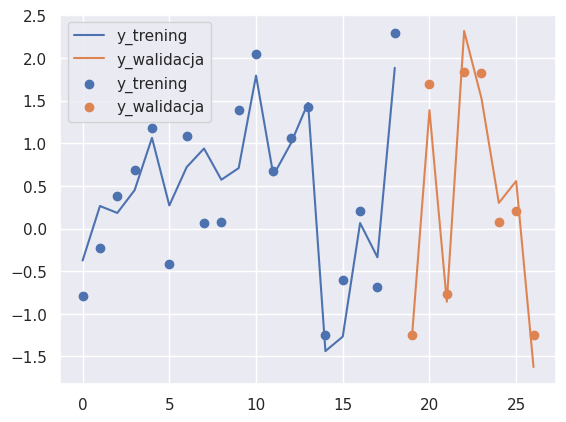

In [72]:
plt.plot(range(X_trening.shape[0]), pred_Y_trening, label="y_trening")
plt.plot(range(X_trening.shape[0], X_trening.shape[0] + X_walidacja.shape[0]),pred_Y_walidacja, label="y_walidacja")
plt.scatter(range(Y_trening.shape[0]), Y_trening, label="y_trening")
plt.scatter(range(Y_trening.shape[0], Y_trening.shape[0] + Y_walidacja.shape[0]), Y_walidacja, label="y_walidacja")
plt.legend()

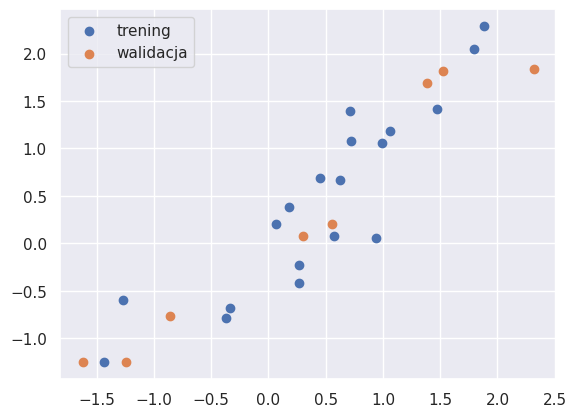

In [73]:
plt.scatter(pred_Y_trening, Y_trening, label="trening")
plt.scatter(pred_Y_walidacja, Y_walidacja, label="walidacja")
plt.legend()

In [74]:
h_i_trening = pl.Series(
    dot(

        dot(

            pl.Series(X_trening.cast(pl.Float64).row(i)).reshape((1,-1)), 
            inv(
                dot(

                    X_trening.cast(pl.Float64).transpose(), 
                    X_trening.cast(pl.Float64)
                    
                )
            )

        ),
        pl.Series(X_trening.cast(pl.Float64).row(i))

    )[0] for i in range(X_trening.shape[0])
)

In [75]:
h_i_trening.head(5)

""
f64
0.132406
0.206094
0.078165
0.112327
0.217848


In [76]:
X_trening

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,i64,i64,i64
-0.63,2,0,2
1.22,1,0,4
0.57,1,0,3
0.68,0,0,3
1.5,0,0,2
…,…,…,…
-0.97,2,0,6
-0.63,3,0,5
0.3,2,0,2


In [77]:
h_i_walidacja = pl.Series(
    dot(

        dot(

            pl.Series(X_walidacja.cast(pl.Float64).row(i)).reshape((1,-1)), 
            inv(
                dot(

                    X_walidacja.cast(pl.Float64).transpose(), 
                    X_walidacja.cast(pl.Float64)
                    
                )
            )

        ),
        pl.Series(X_walidacja.cast(pl.Float64).row(i))

    )[0] for i in range(X_walidacja.shape[0])
)

In [78]:
h_i_walidacja.head(5)

""
f64
0.305044
0.70602
0.587772
0.710626
0.377469


In [79]:
h_star = 3*(X_trening.shape[1]) / X_trening.shape[0]

In [80]:
trening_residuals = Y_trening - pred_Y_trening
stan_trening_residuals = trening_residuals.select((pl.col("logK HSA") - trening_residuals.mean()) / trening_residuals.std())

walidacja_residuals = Y_walidacja - pred_Y_walidacja
stan_walidacja_residuals = walidacja_residuals.select((pl.col("logK HSA") - walidacja_residuals.mean()) / walidacja_residuals.std())

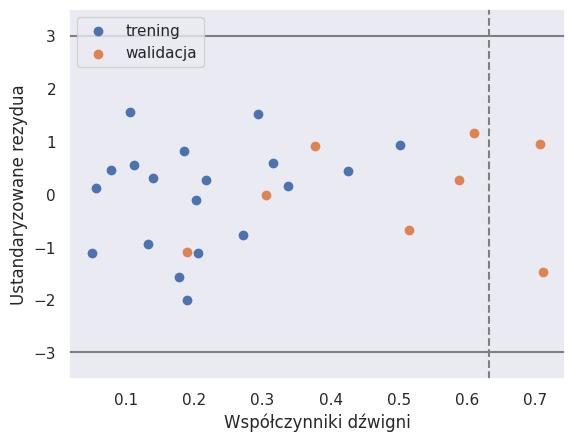

In [81]:
plt.scatter(h_i_trening, stan_trening_residuals, label="trening")
plt.scatter(h_i_walidacja, stan_walidacja_residuals, label="walidacja")
plt.axvline(h_star, linestyle="dashed", color="grey")
plt.axhline(-3, color='grey')
plt.axhline(3, color='grey')
plt.grid()
plt.ylim(-3.5,3.5)
plt.xlabel("Współczynniki dźwigni")
plt.ylabel("Ustandaryzowane rezydua")
plt.legend()

In [82]:
R2(pred_Y_trening, Y_trening)

0.802627713030591

In [83]:
RMSE(pred_Y_trening, Y_trening)

0.42710692427874286

In [84]:
RMSE(pred_Y_walidacja, Y_walidacja)

0.3013587245888068

In [85]:
X_trening.with_row_index().filter(pl.col('index') == 0).drop('index')

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,i64,i64,i64
-0.63,2,0,2


In [86]:
LinearRegression().fit(
        X_trening.with_row_index().filter(pl.col('index') != 0).drop('index'),
        Y_trening.with_row_index().filter(pl.col('index') != 0).drop('index')
    ).predict(
        X_trening.with_row_index().filter(pl.col('index') == 0).drop('index')
    )[0][0]

np.float64(-0.20245343992086307)

In [87]:
pred_Y_cv = pl.Series([LinearRegression()
    .fit(
        X_trening.with_row_index().filter(pl.col('index') != i).drop('index'),
        Y_trening.with_row_index().filter(pl.col('index') != i).drop('index')
    )
    .predict(
        X_trening.with_row_index().filter(pl.col('index') == i).drop('index')
    )[0][0] for i in range(X_trening.shape[0])] 
    )

In [88]:
Q2(pred_Y_cv, Y_trening)

0.6223963031006665

In [89]:
RMSE(pred_Y_cv, Y_trening)

0.5907607652603646

In [90]:
ex_model = LinearRegression().fit(X_trening, Y_trening)

In [91]:
pred_Y_ex = pl.Series(ex_model.predict(X_walidacja).reshape(-1))

In [92]:
Q2(pred_Y_ex, Y_walidacja)

0.942439776973401

In [93]:
RMSE(pred_Y_ex, Y_walidacja)

0.3013587245888068

In [94]:
F(pred_Y_trening, Y_trening, 4)

3.1628857759577413